# DeepFake Detector 

This notebook trains a deepfake detector using FaceForensics dataset. 

FaceForensics provides manipulated videos created using techniques like DeepFake, NeuralTextures, FaceSwap and Face2Face. Videos fall into different compression categories such as raw, c23 & c40. Detection becomes difficult as compression rate increases, but highly compressed videos represent real world scenarios where videos are never in raw form. Eg. social media.

The model in this notebook is trained on c23 compressed videos. 
Additionally, the model is only trained on videos manipulated using DeepFake

### Group frames as fake or real

```python
import os
import shutil
from tqdm import tqdm 

root_dir = "/home/jupyter/data/original_sequences/actors/c23/images/"
dest_dir = "/home/jupyter/data/manually_grouped/originals/"
for root, dirs, files in tqdm(os.walk(root_dir)):
   for dir_name in dirs:
      sub_root_dir = os.path.join(root_dir, dir_name)
      for sub_root, sub_dirs, sub_files in os.walk(sub_root_dir):
         for sub_file_name in sub_files:
            new_file_name = dir_name + "_" + sub_file_name
            shutil.copy(os.path.join(root, dir_name, sub_file_name), os.path.join(dest_dir, new_file_name))
```         

In [3]:
from fastai.vision import *

### Train-Validation Split

In [4]:
path_grouped = Path("/home/jupyter/data/manually_grouped")

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path_grouped, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
data.classes

['fakes', 'originals']

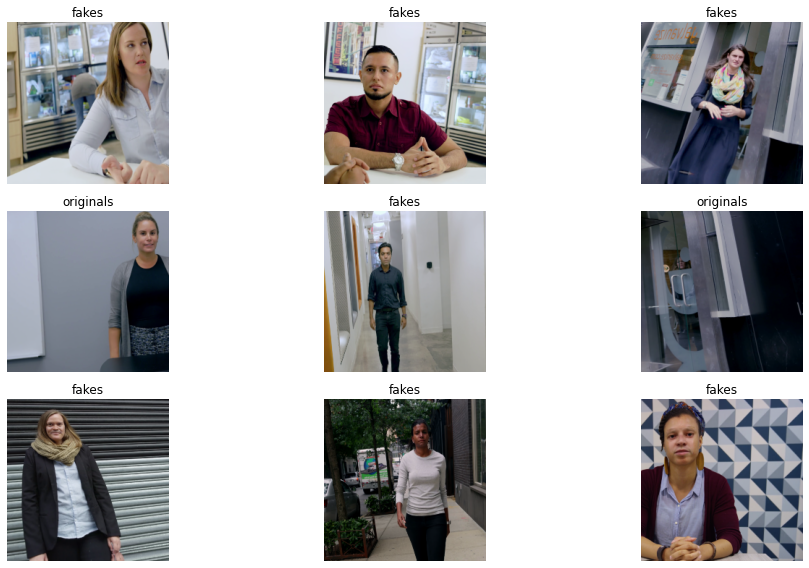

In [7]:
data.show_batch(rows=3, figsize=(15,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['fakes', 'originals'], 2, 29341, 7335)

In [12]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [13]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.291750,0.258299,0.088071,29:49


In [14]:
learn.save('stage-1')

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


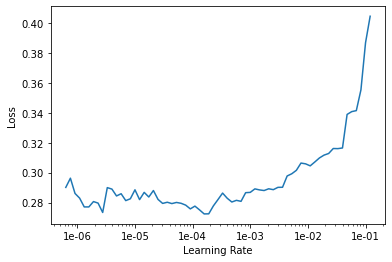

In [17]:
learn.recorder.plot()

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

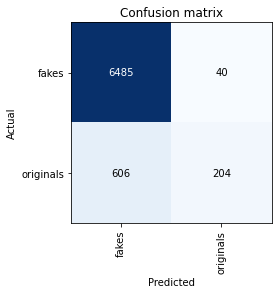

In [19]:
interp.plot_confusion_matrix()

6729 misclassified samples over 7335 samples in the validation set.


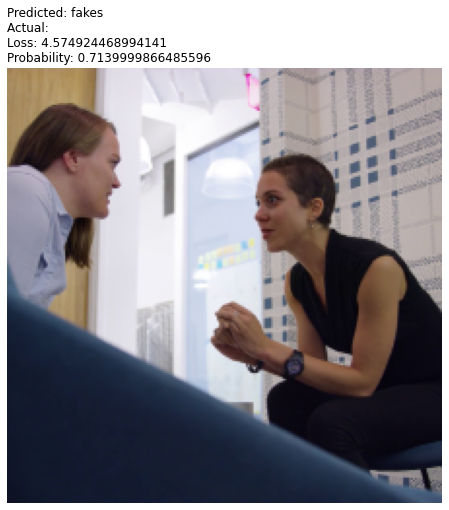

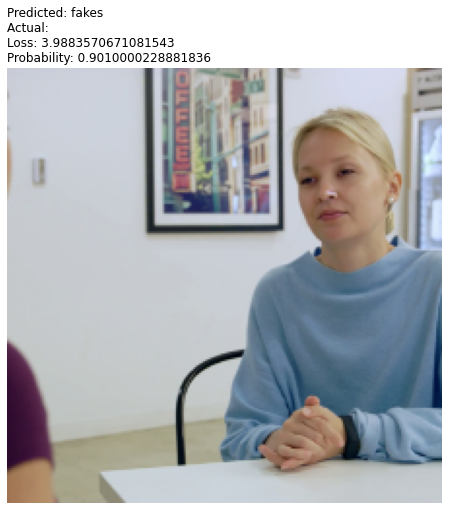

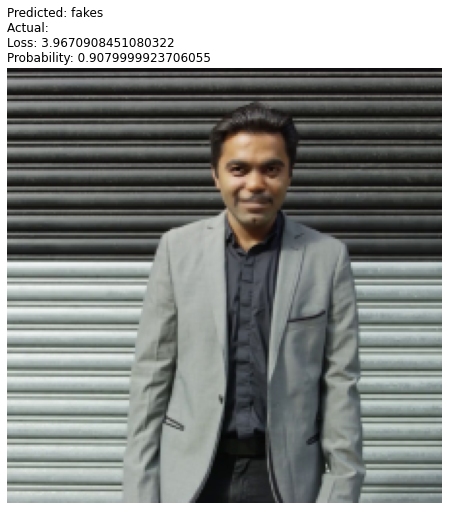

In [22]:
interp.p

In [25]:
interp.plot_top_losses()

TypeError: _cl_int_plot_top_losses() missing 1 required positional argument: 'k'

# Part 2

In [12]:
from fastai.vision import * 

In [13]:
# Fix for image file is truncated error
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [14]:
root_path = Path("/home/jupyter/data")

Real videos are placed in *original_sequences* folder and fakevideos are in *manipulated_sequences* folder. Images can be labelled according to the folder they are in.

In [15]:
originals_path = root_path/'original_sequences'
fakes_path = root_path/'manipulated_sequences'

In [16]:
# Make list of paths to original and fake videos
original_path_list = get_image_files(originals_path, recurse=True)
fake_path_list = get_image_files(fakes_path, recurse=True)

## Data is imbalanced

The dataset is highly imbalanced with 3993 real videos and 322683 fake videos. That's more than 8 fake videos for every real one.

If the model predicted every video to be fake, it would be right 89.11% of the time. 

In [17]:
print(f'Number of real videos: {len(original_path_list)}')
print(f'Number of fake videos: {len(fake_path_list)}')

Number of real videos: 3993
Number of fake videos: 32683


In [18]:
image_path_list = original_path_list + fake_path_list

In [19]:
real_label_list = ['real']*3993
fake_label_list =['fake']*32683
label_list = real_label_list + fake_label_list

In [21]:
data = ImageDataBunch.from_lists(root_path, image_path_list, label_list, valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [22]:
data.classes

['fake', 'real']

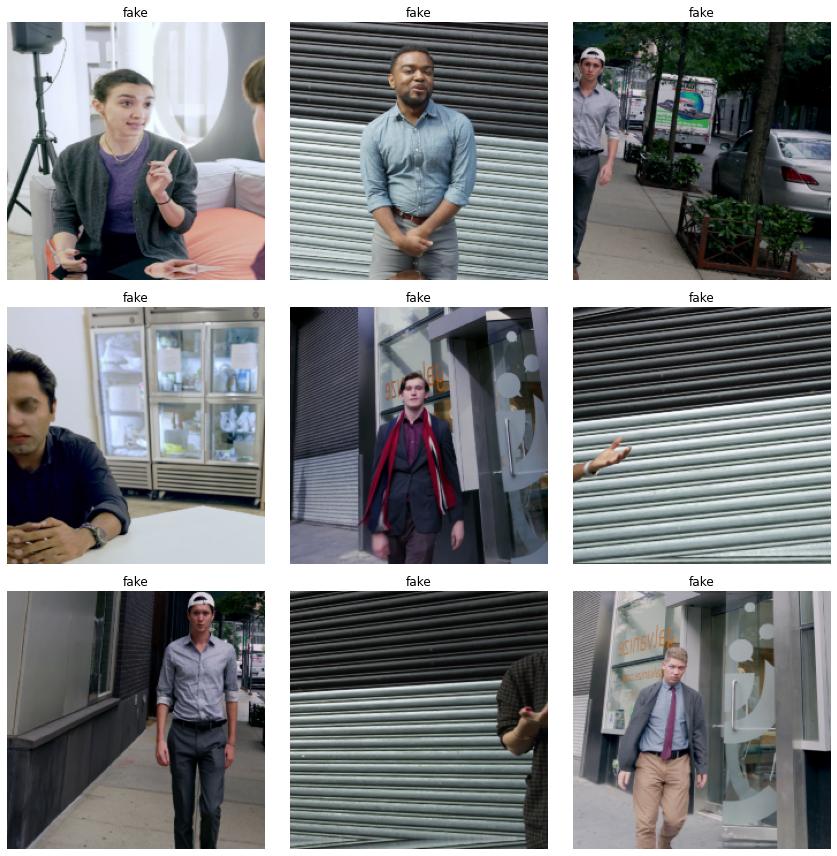

In [14]:
data.show_batch(rows = 3)

In [23]:
print(f'train set size: {len(data.train_ds)}')
print(f'validation set size: {len(data.valid_ds)}')

train set size: 29341
validation set size: 7335


In [16]:
doc(cnn_learner)

In [17]:
f_score = partial(fbeta, thresh=0.2, beta = 1)

In [24]:
learn = cnn_learner(data, models.resnet18,  metrics=accuracy)

In [23]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.342779,0.304373,0.891479,12:47
1,0.282942,0.258908,0.914247,14:07
2,0.265736,0.243491,0.915201,14:13


In [24]:
learn.save('stage-1-3epochs')

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


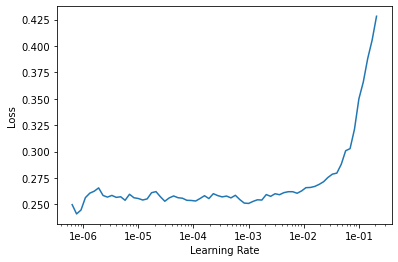

In [26]:
learn.recorder.plot()

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

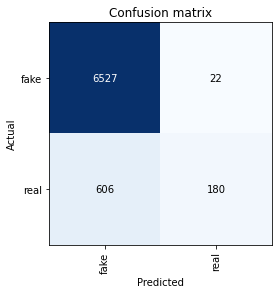

In [39]:

interp.plot_confusion_matrix()

In [40]:
interp.most_confused()

[('real', 'fake', 606), ('fake', 'real', 22)]

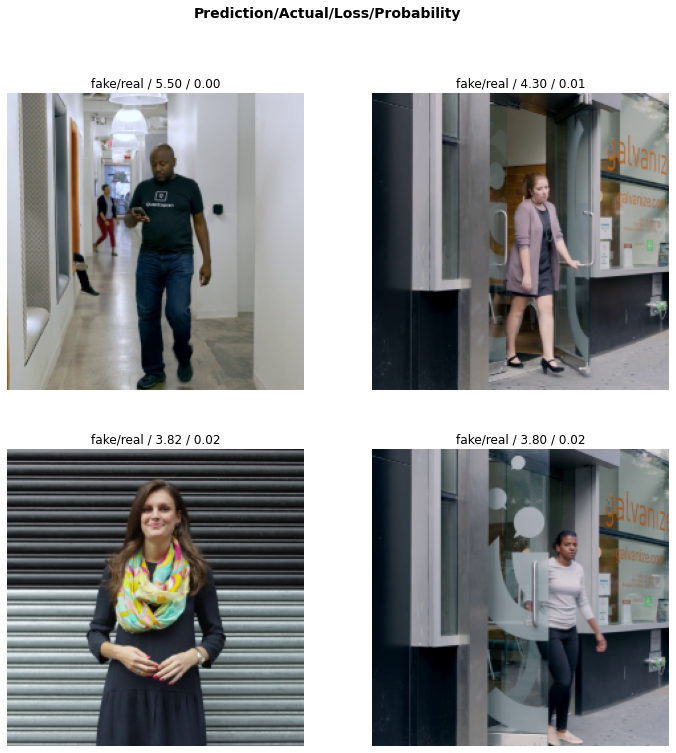

In [42]:
interp.plot_top_losses(4)

In [43]:
doc(interp.plot_top_losses)

## Tune learning rate 

In [25]:
learn.load('stage-1-3epochs')

Learner(data=ImageDataBunch;

Train: LabelList (29341 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
real,real,real,real,real
Path: /home/jupyter/data;

Valid: LabelList (7335 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
fake,fake,fake,fake,fake
Path: /home/jupyter/data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.252025,0.247126,0.910157,16:40
1,0.211336,0.221815,0.918064,16:44
2,0.197562,0.193387,0.928153,16:51


In [28]:
interp = ClassificationInterpretation.from_learner(learn)

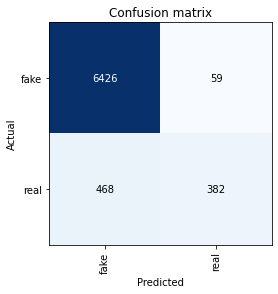

In [29]:
interp.plot_confusion_matrix()

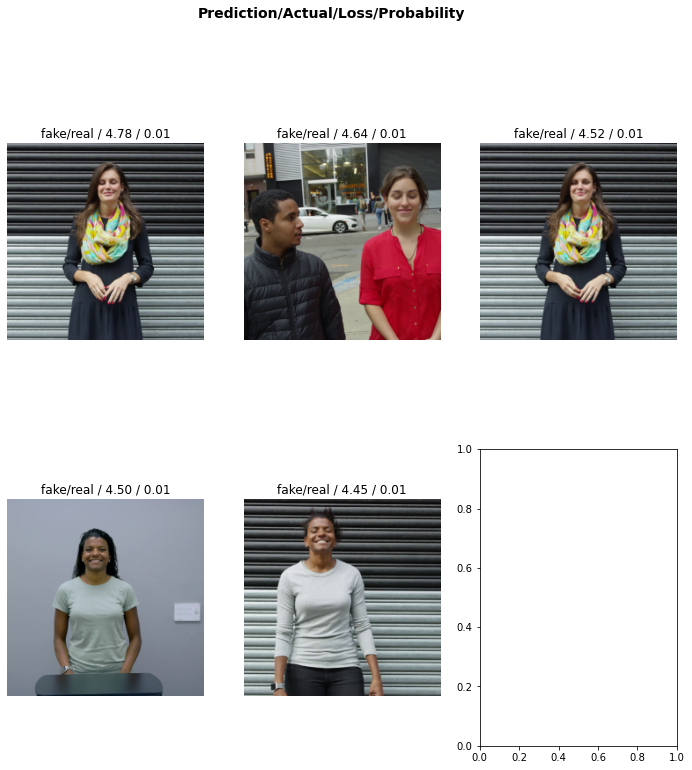

In [31]:
interp.plot_top_losses(5)